In [1]:
import copy
import torch
import optuna
import visualbench as vb

We will use [mnist1d](https://github.com/greydanus/mnist1d) dataset. Each sample in the dataset is a length-40 vector, making it extremely fast to evaluate. At the same time it is more challenging compared to classical MNIST.

To initialize `vb.Mnist1d`, we need a model which accepts a `(batch_size, 40)` input and returns `(batch_size, 10)` logits.

In [2]:
torch.manual_seed(0) # for model weights initiallization

bench = vb.Mnist1d(
    vb.models.vision.ConvNet(in_size=40, in_channels=1, out_channels=10, widths=(128, 256, 512)),
    batch_size=32, test_batch_size=128,
).cuda() # don't forget to move to CUDA!

# disable printing
bench.set_print_inverval(None)

Mnist1d(
  (model): ConvNet(
    (layers): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), bias=False)
        (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
        (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (4): Dropout1d(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), bias=False)
        (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
        (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (4): Dropout1d(p=0.2, inplace=False)
      )
      (2): Sequential(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), bias=False)
        (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
        (3): BatchNorm1d(512, eps=1e-05

The objective will be to minimize lowest recorded test loss. `bench.logger["test loss"]` is a dictionary which maps current step to test loss values, but it also has some extra methods such as `last(metric)` - returns last value, `min(metric)` - returns smallest value, `nanmin(metric)` - returns smallest value while ignoring nans.

In optuna objective we set trial to the benchmark by calling `bench.set_optuna_trial(trial, metric="test loss")`.

Now whenever `"test loss"` is logged in the benchmark, it reports it to the trial (it calls `trial.report`) and checks if the trial should be pruned (calls `trial.should_prune()`). 

If trial should be pruned, it raises `optuna.TrialPruned()`.

In [3]:
def objective(trial: optuna.Trial):
    # reset benchmark, this is much faster than recreating from scratch,
    # as it doesn't have to preprocess the dataset again
    # (don't do this with multiprocessing)
    bench.reset()

    # since we don't need visualization, enable performance mode
    bench.set_performance_mode()

    # set trial to benchmark
    bench.set_optuna_trial(trial, metric="test loss")

    # create optimizer with suggested hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1, log=True)
    beta1 = 1 - trial.suggest_float("beta1", 1e-5, 1, log=True)
    beta2 = 1 - trial.suggest_float("beta2", 1e-5, 1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1, log=True)
    opt = torch.optim.AdamW(bench.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)

    # run and return lowest test loss
    bench.run(opt, 1_000, test_every_batches=50)
    return bench.logger.nanmin("test loss") # or bench.logger.last("test loss")

# create a study
sampler = optuna.samplers.TPESampler(seed=0, multivariate=True)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(pruner = pruner)

# optuna.logging.disable_default_handler() # to disable optuna logs

# optimize
study.enqueue_trial(dict(lr=1e-3, beta1=0.9, beta2=0.999, weight_decay=0.01)) # defaults to start with
study.optimize(objective, timeout=600, show_progress_bar=True)

/var/mnt/issd/dev/miniconda3/envs/pytorch312/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-05 10:46:48,598] A new study created in memory with name: no-name-9cfecae0-0d56-4ca9-943e-180f7d0fd2b5


   0%|          | 00:00/10:00

[I 2025-10-05 10:46:53,163] Trial 0 finished with value: 1.132008045911789 and parameters: {'lr': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'weight_decay': 0.01}. Best is trial 0 with value: 1.132008045911789.
[I 2025-10-05 10:46:57,708] Trial 1 finished with value: 1.104976400732994 and parameters: {'lr': 0.0016792013989512695, 'beta1': 0.9435369512566462, 'beta2': 0.21029313442248707, 'weight_decay': 2.2275695459371494e-05}. Best is trial 1 with value: 1.104976400732994.
[I 2025-10-05 10:46:57,954] Trial 2 pruned. 
[I 2025-10-05 10:46:58,236] Trial 3 pruned. 
[I 2025-10-05 10:47:02,796] Trial 4 finished with value: 1.304055243730545 and parameters: {'lr': 2.867325870009652e-05, 'beta1': 0.0004891380723783495, 'beta2': 0.9862064885361044, 'weight_decay': 3.145910873690651e-05}. Best is trial 1 with value: 1.104976400732994.
[I 2025-10-05 10:47:03,047] Trial 5 pruned. 
[I 2025-10-05 10:47:03,556] Trial 6 pruned. 
[I 2025-10-05 10:47:03,838] Trial 7 pruned. 
[I 2025-10-05 10:47:04,072] Trial

In [4]:
optuna.visualization.plot_optimization_history(study)

In [5]:
print(f'{study.best_params = }')
print(f'{study.best_value = }')

study.best_params = {'lr': 0.0015015752366802284, 'beta1': 0.8189504559481735, 'beta2': 0.32682952753554767, 'weight_decay': 0.6493305679230552}
study.best_value = 1.0294789671897888


Now we can run the benchmark with the best parameters. We should get exactly the same test loss as the benchmark is reproducible.

bench.logger.nanmin("test loss") = np.float64(1.0165292546153069)


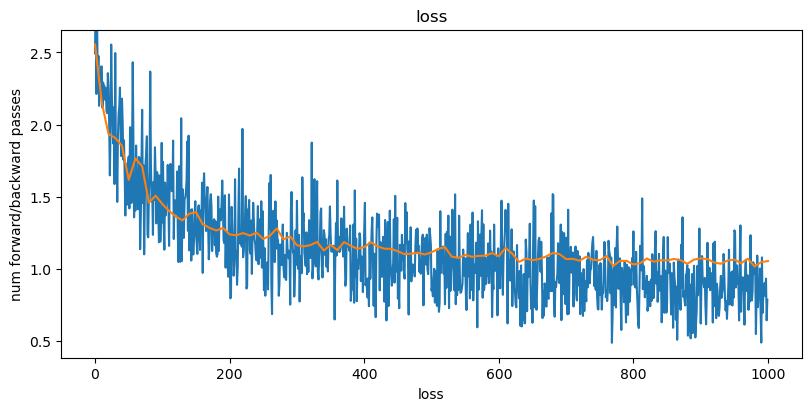

In [8]:
bench.reset()
bench.eval()

lr = study.best_params["lr"]
beta1 = 1 - study.best_params["beta1"]
beta2 = 1 - study.best_params["beta2"]
weight_decay = study.best_params["weight_decay"]
opt = torch.optim.AdamW(bench.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)

bench.run(opt, 1_000, test_every_batches=10)
print(f'{bench.logger.nanmin("test loss") = }')

bench.plot()